In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns

from sklearn.metrics import accuracy_score, log_loss
import xgboost as xgb
from sklearn.model_selection import GroupKFold

plt.style.use("fivethirtyeight")
mypal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
!ls -GFlash ../input/march-machine-learning-mania-2024/

total 144M
   0 drwxr-xr-x 2 nobody    0 May 13 08:49 ./
4.0K drwxr-xr-x 3 root   4.0K Jun 12 12:38 ../
4.0K -rw-r--r-- 1 nobody 1.4K May 13 08:49 2024_tourney_seeds.csv
 12K -rw-r--r-- 1 nobody 9.1K May 13 08:49 Cities.csv
4.0K -rw-r--r-- 1 nobody 1.7K May 13 08:49 Conferences.csv
168K -rw-r--r-- 1 nobody 168K May 13 08:49 MConferenceTourneyGames.csv
2.5M -rw-r--r-- 1 nobody 2.5M May 13 08:49 MGameCities.csv
111M -rw-r--r-- 1 nobody 111M May 13 08:49 MMasseyOrdinals_thruSeason2024_day128.csv
 72K -rw-r--r-- 1 nobody  72K May 13 08:49 MNCAATourneyCompactResults.csv
132K -rw-r--r-- 1 nobody 129K May 13 08:49 MNCAATourneyDetailedResults.csv
 16K -rw-r--r-- 1 nobody  16K May 13 08:49 MNCAATourneySeedRoundSlots.csv
 40K -rw-r--r-- 1 nobody  38K May 13 08:49 MNCAATourneySeeds.csv
 52K -rw-r--r-- 1 nobody  50K May 13 08:49 MNCAATourneySlots.csv
5.3M -rw-r--r-- 1 nobody 5.3M May 13 08:49 MRegularSeasonCompactResults.csv
 11M -rw-r--r-- 1 nobody  11M May 13 08:49 MRegularSeasonDetailedResults.

# **Files we are interested in:**

* ***MRegularSeasonCompactResults.csv & WMRegularSeasonCompactResults.csv**

    All game results from the regular season.
* **MNCAATourneyCompactResults.csv & WNCAATourneyCompactResults.csv**

    All game results from past tournaments.
* **MNCAATourneySeeds.csv & MNCAATourneySeeds.csv**

     The seeding for the tournaments
* *** 2024_tourney_seeds.csv**

   File that will be updated with 2024 seeds once released (2023 seeds prior to that)

In [3]:
DATA_PATH = "../input/march-machine-learning-mania-2024/"

In [4]:
df_seeds = pd.concat(
    [
        pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv").assign(League="M"),
        pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv").assign(League="W"),
    ],
).reset_index(drop=True)

df_season_results = pd.concat(
    [
        pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv").assign(League="M"),
        pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv").assign(League="W"),
    ]
).reset_index(drop=True)

df_tourney_results = pd.concat(
    [
        pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv").assign(League="M"),
        pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv").assign(League="W"),
    ]
).reset_index(drop=True)

In [5]:
Season = 2024
filtered_wins =  df_seeds[ df_seeds['Season'] == Season]
filtered_wins

,Season,Seed,TeamID,League
2490,2024,W01,1163,M
2491,2024,W02,1235,M
2492,2024,W03,1228,M
2493,2024,W04,1120,M
2494,2024,W05,1361,M
...,...,...,...,...
4229,2024,Z12b,3435,W
4230,2024,Z13,3267,W
4231,2024,Z14,3238,W
4232,2024,Z15,3263,W


# **Creating Team Season Results**

* We the the data from the existing format with 1 row per game
* New format has 1 row for each team's game - win or loss.
* This data can be aggregated for season metrics

In [6]:
df_team_season_results = pd.concat(
    [
        df_season_results[["Season", "League", "WTeamID", "DayNum", "WScore", "LScore"]]
        .assign(GameResult="W")
        .rename(
            columns={"WTeamID": "TeamID", "WScore": "TeamScore", "LScore": "OppScore"}
        ),
        df_season_results[["Season", "League", "LTeamID", "DayNum", "WScore", "LScore"]]
        .assign(GameResult="L")
        .rename(
            columns={"LTeamID": "TeamID", "LScore": "TeamScore", "WScore": "OppScore"}
        ),
    ]
).reset_index(drop=True)

# Create Season Features

* add some features to this data like the score differential

In [7]:
# Score Differential
df_team_season_results["ScoreDiff"] = (
    df_team_season_results["TeamScore"] - df_team_season_results["OppScore"]
)
df_team_season_results["Win"] = (df_team_season_results["GameResult"] == "W").astype(
    "int"
)

In [8]:
df_team_season_results.sample(10, random_state=529)

,Season,League,TeamID,DayNum,TeamScore,OppScore,GameResult,ScoreDiff,Win
493232,2022,M,1444,96,64,77,L,-13,0
71811,2002,M,1281,79,74,50,W,24,1
555548,2008,W,3276,115,67,69,L,-2,0
84226,2005,M,1393,40,86,56,W,30,1
129439,2014,M,1368,8,63,62,W,1,1
364900,1996,M,1148,85,46,116,L,-70,0
587485,2015,W,3394,18,66,68,L,-2,0
397470,2003,M,1266,129,76,83,L,-7,0
99374,2008,M,1177,47,93,88,W,5,1
532105,2003,W,3414,130,50,83,L,-33,0


# Aggregate for team's total season stats



In [9]:
# Aggregate the data
team_season_agg = (
    df_team_season_results.groupby(["Season", "TeamID", "League"])
    .agg(
        AvgScoreDiff=("ScoreDiff", "mean"),
        MedianScoreDiff=("ScoreDiff", "median"),
        MinScoreDiff=("ScoreDiff", "min"),
        MaxScoreDiff=("ScoreDiff", "max"),
        Wins=("Win", "sum"),
        Losses=("GameResult", lambda x: (x == "L").sum()),
        WinPercentage=("Win", "mean"),
    )
    .reset_index()
)

In [10]:
team_season_agg.head()

,Season,TeamID,League,AvgScoreDiff,MedianScoreDiff,MinScoreDiff,MaxScoreDiff,Wins,Losses,WinPercentage
0,1985,1102,M,-5.791667,-5.5,-41,29,5,19,0.208333
1,1985,1103,M,-3.043478,-2.0,-22,16,9,14,0.391304
2,1985,1104,M,7.800000,6.5,-12,25,21,9,0.700000
3,1985,1106,M,-3.791667,-1.5,-35,28,10,14,0.416667
4,1985,1108,M,7.960000,4.0,-15,35,19,6,0.760000


In [11]:
df_seeds["ChalkSeed"] = (
    df_seeds["Seed"].str.replace("a", "").str.replace("b", "").str[1:].astype("int")
)

team_season_agg = team_season_agg.merge(
    df_seeds, on=["Season", "TeamID", "League"], how="left"
)

In [12]:
team_season_agg.shape, df_seeds.shape

((22150, 12), (4234, 5))

# Tournament Results Aggregation

In [13]:
df_team_tourney_results = pd.concat(
    [
        df_tourney_results[
            ["Season", "League", "WTeamID", "LTeamID", "WScore", "LScore"]
        ]
        .assign(GameResult="W")
        .rename(
            columns={
                "WTeamID": "TeamID",
                "LTeamID": "OppTeamID",
                "WScore": "TeamScore",
                "LScore": "OppScore",
            }
        ),
        df_tourney_results[
            ["Season", "League", "LTeamID", "WTeamID", "LScore", "WScore"]
        ]
        .assign(GameResult="L")
        .rename(
            columns={
                "LTeamID": "TeamID",
                "WTeamID": "OppTeamID",
                "LScore": "TeamScore",
                "WScore": "OppScore",
            }
        ),
    ]
).reset_index(drop=True)

df_team_tourney_results["Win"] = (df_team_tourney_results["GameResult"] == "W").astype(
    "int"
)

In [14]:
df_team_tourney_results.head()

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win
0,1985,M,1116,1234,63,54,W,1
1,1985,M,1120,1345,59,58,W,1
2,1985,M,1207,1250,68,43,W,1
3,1985,M,1229,1425,58,55,W,1
4,1985,M,1242,1325,49,38,W,1


# Tourney Dataset with Features

* merge our team's regular season features with our tourney dataframe.
* This gives us the data format that we will use to train our model.
* target column is the "Winner" and the features are the regular season stats.

In [15]:
df_historic_tourney_features = df_team_tourney_results.merge(
    team_season_agg[
        ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff", "ChalkSeed"]
    ],
    on=["Season", "League", "TeamID"],
    how="left",
).merge(
    team_season_agg[
        ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff", "ChalkSeed"]
    ].rename(
        columns={
            "TeamID": "OppTeamID",
            "WinPercentage": "OppWinPercentage",
            "MedianScoreDiff": "OppMedianScoreDiff",
            "ChalkSeed": "OppChalkSeed",
        }
    ),
    on=["Season", "League", "OppTeamID"],
)

In [16]:
df_historic_tourney_features.head()

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win,WinPercentage,MedianScoreDiff,ChalkSeed,OppWinPercentage,OppMedianScoreDiff,OppChalkSeed
0,1985,M,1116,1234,63,54,W,1,0.636364,5.0,9.0,0.666667,9.5,8.0
1,1985,M,1120,1345,59,58,W,1,0.620690,2.0,11.0,0.680000,9.0,6.0
2,1985,M,1207,1250,68,43,W,1,0.925926,14.0,1.0,0.379310,-3.0,16.0
3,1985,M,1229,1425,58,55,W,1,0.740741,6.0,9.0,0.678571,2.5,8.0
4,1985,M,1242,1325,49,38,W,1,0.766667,5.5,3.0,0.740741,6.0,14.0


In [17]:
 df_historic_tourney_features.columns

Index(['Season', 'League', 'TeamID', 'OppTeamID', 'TeamScore', 'OppScore',
       'GameResult', 'Win', 'WinPercentage', 'MedianScoreDiff', 'ChalkSeed',
       'OppWinPercentage', 'OppMedianScoreDiff', 'OppChalkSeed'],
      dtype='object')

In [18]:
df_historic_tourney_features["WinPctDiff"] = (
    df_historic_tourney_features["WinPercentage"]
    - df_historic_tourney_features["OppWinPercentage"]
)

df_historic_tourney_features["ChalkSeedDiff"] = (
    df_historic_tourney_features["ChalkSeed"]
    - df_historic_tourney_features["OppChalkSeed"]
)

df_historic_tourney_features["MedianScoreDiffDiff"] = (
    df_historic_tourney_features["MedianScoreDiff"]
    - df_historic_tourney_features["OppMedianScoreDiff"]
)

In [19]:
df_historic_tourney_features

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win,WinPercentage,MedianScoreDiff,ChalkSeed,OppWinPercentage,OppMedianScoreDiff,OppChalkSeed,WinPctDiff,ChalkSeedDiff,MedianScoreDiffDiff
0,1985,M,1116,1234,63,54,W,1,0.636364,5.0,9.0,0.666667,9.5,8.0,-0.030303,1.0,-4.5
1,1985,M,1120,1345,59,58,W,1,0.620690,2.0,11.0,0.680000,9.0,6.0,-0.059310,5.0,-7.0
2,1985,M,1207,1250,68,43,W,1,0.925926,14.0,1.0,0.379310,-3.0,16.0,0.546616,-15.0,17.0
3,1985,M,1229,1425,58,55,W,1,0.740741,6.0,9.0,0.678571,2.5,8.0,0.062169,1.0,3.5
4,1985,M,1242,1325,49,38,W,1,0.766667,5.5,3.0,0.740741,6.0,14.0,0.025926,-11.0,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,2023,W,3268,3376,75,86,L,0,0.806452,11.0,2.0,1.000000,28.0,1.0,-0.193548,1.0,-17.0
8064,2023,W,3326,3439,74,84,L,0,0.781250,12.0,3.0,0.870968,13.0,1.0,-0.089718,2.0,-1.0
8065,2023,W,3376,3234,73,77,L,0,1.000000,28.0,1.0,0.812500,13.5,2.0,0.187500,-1.0,14.5
8066,2023,W,3439,3261,72,79,L,0,0.870968,13.0,1.0,0.933333,22.0,3.0,-0.062366,-2.0,-9.0


In [20]:
TeamID = 1116
filtered_wins =  df_historic_tourney_features[ df_historic_tourney_features['TeamID'] == TeamID]
filtered_wins

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win,WinPercentage,MedianScoreDiff,ChalkSeed,OppWinPercentage,OppMedianScoreDiff,OppChalkSeed,WinPctDiff,ChalkSeedDiff,MedianScoreDiffDiff
0,1985,M,1116,1234,63,54,W,1,0.636364,5.0,9.0,0.666667,9.5,8.0,-0.030303,1.0,-4.5
253,1989,M,1116,1258,120,101,W,1,0.800000,16.5,5.0,0.655172,5.0,12.0,0.144828,-7.0,11.5
315,1990,M,1116,1343,68,64,W,1,0.866667,15.0,4.0,0.750000,11.5,13.0,0.116667,-9.0,3.5
347,1990,M,1116,1173,86,84,W,1,0.866667,15.0,4.0,0.700000,6.0,12.0,0.166667,-8.0,9.0
363,1990,M,1116,1314,96,73,W,1,0.866667,15.0,4.0,0.612903,5.0,8.0,0.253763,-4.0,10.0
371,1990,M,1116,1400,88,85,W,1,0.866667,15.0,4.0,0.700000,6.0,10.0,0.166667,-6.0,9.0
396,1991,M,1116,1209,117,76,W,1,0.909091,20.0,1.0,0.533333,1.0,16.0,0.375758,-15.0,19.0
419,1991,M,1116,1113,97,90,W,1,0.909091,20.0,1.0,0.678571,6.0,8.0,0.230519,-7.0,14.0
426,1991,M,1116,1104,93,70,W,1,0.909091,20.0,1.0,0.700000,5.5,4.0,0.209091,-3.0,14.5
442,1992,M,1116,1293,80,69,W,1,0.758621,11.0,3.0,0.571429,3.0,14.0,0.187192,-11.0,8.0


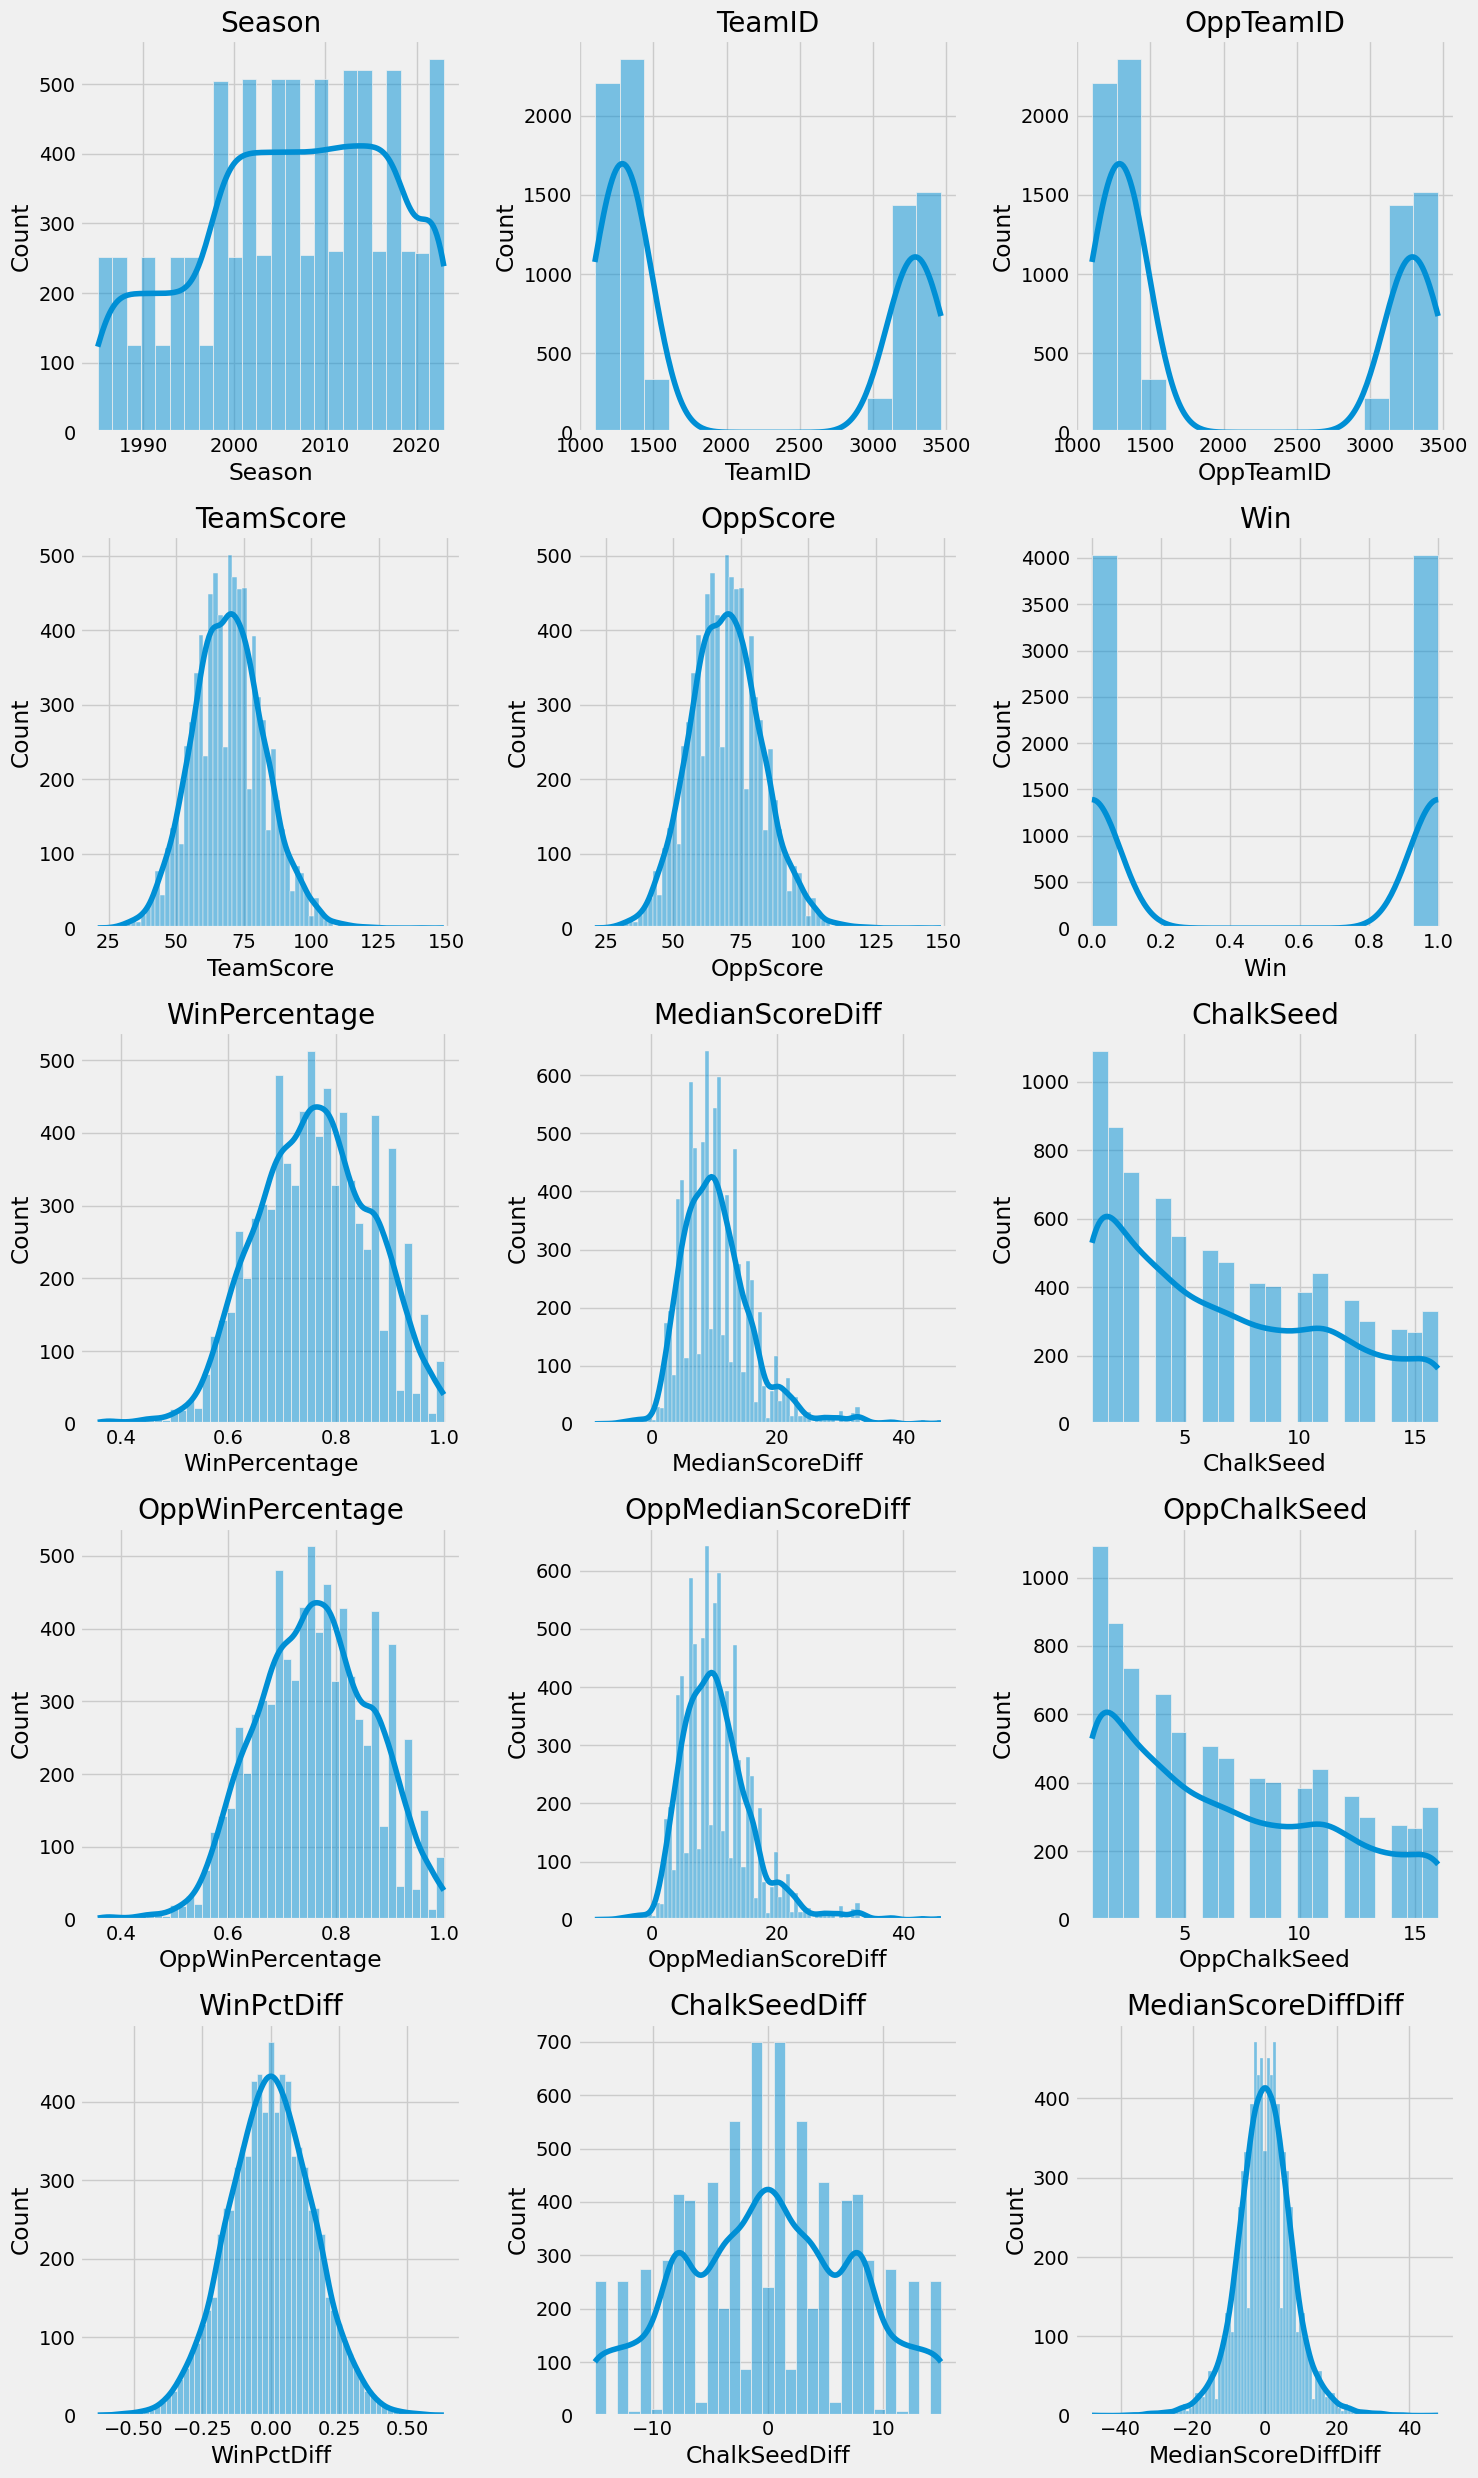

In [21]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Suppress all warnings
warnings.filterwarnings('ignore')

# Replace infinite values with NaN
df_historic_tourney_features.replace([np.inf, -np.inf], np.nan, inplace=True)


# Get numerical features
numerical_features = df_historic_tourney_features.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows and columns for subplots
num_features = len(numerical_features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

plt.figure(figsize=(15, num_rows * 5))
for i, col in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df_historic_tourney_features[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

# Baseline - Higher Seed Wins
To do this we will simply score the accuracy on historic tournaments assuming the higher seed always wins.

In [22]:
df_historic_tourney_features["BaselinePred"] = (
    df_historic_tourney_features["ChalkSeed"]
    < df_historic_tourney_features["OppChalkSeed"]
)

df_historic_tourney_features.loc[
    df_historic_tourney_features["ChalkSeed"]
    == df_historic_tourney_features["OppChalkSeed"],
    "BaselinePred",
] = (
    df_historic_tourney_features["WinPercentage"]
    > df_historic_tourney_features["OppWinPercentage"]
)

In [23]:
from sklearn.metrics import accuracy_score, log_loss

cv_scores_baseline = []
for season in df_historic_tourney_features["Season"].unique():
    pred = df_historic_tourney_features.query("Season == @season")[
        "BaselinePred"
    ].astype("int")
    y = df_historic_tourney_features.query("Season == @season")["Win"]
    score = accuracy_score(y, pred)
    score_ll = log_loss(y, pred)
    cv_scores_baseline.append(score)
    print(f"Holdout season {season} - Accuracy {score:0.4f} Log Loss {score_ll:0.4f}")

print(f"Baseline accuracy {np.mean(cv_scores_baseline):0.4f}")

Holdout season 1985 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1986 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1987 - Accuracy 0.6984 Log Loss 10.8703
Holdout season 1988 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1989 - Accuracy 0.6667 Log Loss 12.0146
Holdout season 1990 - Accuracy 0.6825 Log Loss 11.4424
Holdout season 1991 - Accuracy 0.7460 Log Loss 9.1539
Holdout season 1992 - Accuracy 0.7619 Log Loss 8.5818
Holdout season 1993 - Accuracy 0.7937 Log Loss 7.4376
Holdout season 1994 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1995 - Accuracy 0.7619 Log Loss 8.5818
Holdout season 1996 - Accuracy 0.7460 Log Loss 9.1539
Holdout season 1997 - Accuracy 0.7302 Log Loss 9.7261
Holdout season 1998 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1999 - Accuracy 0.7222 Log Loss 10.0121
Holdout season 2000 - Accuracy 0.7302 Log Loss 9.7261
Holdout season 2001 - Accuracy 0.7047 Log Loss 10.6428
Holdout season 2002 - Accuracy 0.7480 Log Loss 9.0819
Holdout season 200

# XGBoost Model

In [24]:
FEATURES = [
       "WinPercentage",
        "MedianScoreDiff",
        "ChalkSeed",
       "OppWinPercentage",
        "OppMedianScoreDiff",
        "OppChalkSeed",
    "WinPctDiff",
        "ChalkSeedDiff"
]
TARGET = "Win"


X = df_historic_tourney_features[FEATURES]
y = df_historic_tourney_features[TARGET]
groups = df_historic_tourney_features["Season"]
seasons = df_historic_tourney_features["Season"].unique()

# Setup cross-validation
gkf = GroupKFold(n_splits=df_historic_tourney_features["Season"].nunique())
cv_results = []
models = []

season_idx = 0
for train_index, test_index in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Prepare the model
    model = xgb.XGBRegressor(
        eval_metric="logloss",
        n_estimators=1_000,
        learning_rate=0.001,
    )
    holdout_season = seasons[season_idx]
    print(f"Holdout Season: {holdout_season}")
    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

    # Predict on the test set
    y_pred = model.predict(X_test)
    score_ll = log_loss(y_test, y_pred)
    y_pred = y_pred > 0.5
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    cv_results.append(accuracy)
    season_idx += 1
    print(f"Season {holdout_season}: {accuracy} {score_ll}")
    models.append(model)
# Print the average accuracy across all folds
print("Average CV Accuracy:", np.mean(cv_results))

Holdout Season: 1985
[0]	validation_0-logloss:0.69289
[100]	validation_0-logloss:0.66959
[200]	validation_0-logloss:0.65069
[300]	validation_0-logloss:0.63538
[400]	validation_0-logloss:0.62238
[500]	validation_0-logloss:0.61101
[600]	validation_0-logloss:0.60165
[700]	validation_0-logloss:0.59384
[800]	validation_0-logloss:0.58727
[900]	validation_0-logloss:0.58168
[999]	validation_0-logloss:0.57783
Season 1985: 0.7388059701492538 0.5778297953897061
Holdout Season: 1986
[0]	validation_0-logloss:0.69288
[100]	validation_0-logloss:0.66882
[200]	validation_0-logloss:0.64906
[300]	validation_0-logloss:0.63319
[400]	validation_0-logloss:0.61992
[500]	validation_0-logloss:0.60787
[600]	validation_0-logloss:0.59805
[700]	validation_0-logloss:0.59025
[800]	validation_0-logloss:0.58413
[900]	validation_0-logloss:0.57886
[999]	validation_0-logloss:0.57464
Season 1986: 0.6902985074626866 0.5746410916790947
Holdout Season: 1987
[0]	validation_0-logloss:0.69279
[100]	validation_0-logloss:0.65966
[

# Predict on Test Set

Now that we've trained our models. We can use them to predict on our future data.

In [25]:
TEST_SEASON = 2024  # Change to 2024 when it comes out!

seeds_2024 = pd.read_csv(DATA_PATH + "2024_tourney_seeds.csv")

seeds_2024["ChalkSeed"] = (
    seeds_2024["Seed"].str.replace("a", "").str.replace("b", "").str[1:].astype("int")
)

# Tourney Pairs

* We don't know which teams will play each other in later rounds, so we create a tourney_pairs dataframe.
* This dataframe has all possible combinations of games. We will use our model to predict these.

In [26]:
tourney_pairs = (
    seeds_2024.merge(seeds_2024, on=["Tournament"], suffixes=("", "Opp"))
    .assign(Season=TEST_SEASON)
    .query("TeamID != TeamIDOpp")
    .rename(columns={"Tournament": "League"})
)

tourney_pairs = (
    tourney_pairs.merge(
        team_season_agg[
            ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff"]
        ],
        on=["Season", "League", "TeamID"],
        how="left",
    )
    .merge(
        team_season_agg[
            ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff"]
        ].rename(
            columns={
                "TeamID": "TeamIDOpp",
                "WinPercentage": "OppWinPercentage",
                "MedianScoreDiff": "OppMedianScoreDiff",
            }
        ),
        on=["Season", "League", "TeamIDOpp"],
    )
    .reset_index(drop=True)
)

tourney_pairs["OppChalkSeed"] = (
    tourney_pairs["SeedOpp"]
    .str.replace("a", "")
    .str.replace("b", "")
    .str[1:]
    .astype("int")
)

# Add Features to 2024

In [27]:


tourney_pairs["BaselinePred"] = (
    tourney_pairs["ChalkSeed"] < tourney_pairs["OppChalkSeed"]
)

tourney_pairs.loc[
    tourney_pairs["ChalkSeed"] == tourney_pairs["OppChalkSeed"],
    "BaselinePred",
] = (
    tourney_pairs["WinPercentage"] > tourney_pairs["OppWinPercentage"]
)

tourney_pairs["WinPctDiff"] = (
    tourney_pairs["WinPercentage"] - tourney_pairs["OppWinPercentage"]
)

tourney_pairs["ChalkSeedDiff"] = (
    tourney_pairs["ChalkSeed"] - tourney_pairs["OppChalkSeed"]
)

tourney_pairs["MedianScoreDiffDiff"] = (
    tourney_pairs["MedianScoreDiff"] - tourney_pairs["OppMedianScoreDiff"]
)

In [28]:
tourney_pairs.head()

,League,Seed,TeamID,ChalkSeed,SeedOpp,TeamIDOpp,ChalkSeedOpp,Season,WinPercentage,MedianScoreDiff,OppWinPercentage,OppMedianScoreDiff,OppChalkSeed,BaselinePred,WinPctDiff,ChalkSeedDiff,MedianScoreDiffDiff
0,M,W01,1163,1,W02,1235,2,2024,0.911765,14.0,0.794118,10.0,2,True,0.117647,-1,4.0
1,M,W01,1163,1,W03,1228,3,2024,0.911765,14.0,0.764706,9.5,3,True,0.147059,-2,4.5
2,M,W01,1163,1,W04,1120,4,2024,0.911765,14.0,0.794118,17.0,4,True,0.117647,-3,-3.0
3,M,W01,1163,1,W05,1361,5,2024,0.911765,14.0,0.687500,8.5,5,True,0.224265,-4,5.5
4,M,W01,1163,1,W06,1140,6,2024,0.911765,14.0,0.696970,9.0,6,True,0.214795,-5,5.0


# Create Predictions and Aggregate

* Loop through each of the models we trained before and predict on the latest tourney seed data.

In [29]:
for i, model in enumerate(models):
    tourney_pairs[f"pred_model{i}"] = model.predict(tourney_pairs[FEATURES])

In [30]:
tourney_pairs["Pred"] = tourney_pairs[
    [f for f in tourney_pairs.columns if "model" in f]
].mean(axis=1)

tourney_pairs["ID"] = (
    tourney_pairs["Season"].astype("str")
    + "_"
    + tourney_pairs["TeamID"].astype("str")
    + "_"
    + tourney_pairs["TeamIDOpp"].astype("str")
)

preds = tourney_pairs.copy()

# Simulate Bracket

* Now we have probabilites for every possible combination of possible games in the tournament.
* We want to convert this into a standard "bracket" format.
* To do this we simulate each round and select the highest scored team.

In [31]:
from tqdm import tqdm

# Load and filter data
round_slots = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySlots.csv"
)
round_slots = round_slots[round_slots["Season"] == 2024]
round_slots = round_slots[
    round_slots["Slot"].str.contains("R")
]  # Filter out First Four

seeds = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2024/2024_tourney_seeds.csv"
)
seeds_m = seeds[seeds["Tournament"] == "M"]
seeds_w = seeds[seeds["Tournament"] == "W"]

preds["ID"] = preds["ID"].str.split("_")

In [32]:
def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index("Seed")["TeamID"].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}

    for teams, proba in zip(preds["ID"], preds["Pred"]):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, sim=True):
    
    winners = []
    slots = []

    for slot, strong, weak in zip(
        round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed
    ):
        team_1, team_2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team_1)][str(team_2)]

        if sim:
            # Randomly determine the winner based on the probability
            winner = np.random.choice([team_1, team_2], p=[proba, 1 - proba])
        else:
            # Determine the winner based on the higher probability
            winner = [team_1, team_2][np.argmax([proba, 1 - proba])]

        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets + 1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, sim)

        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({"Bracket": bracket, "Slot": slots, "Team": results})

    return result_df


n_brackets = 1
result_m = run_simulation(
    brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=False
)
result_m["Tournament"] = "M"
result_w = run_simulation(
    brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=False
)
result_w["Tournament"] = "W"
submission = pd.concat([result_m, result_w])
submission = submission.reset_index(drop=True)
submission.index.names = ["RowId"]
submission = submission.reset_index()

100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


In [33]:
ss = pd.read_csv(DATA_PATH + "sample_submission.csv")
submission[ss.columns] = submission[ss.columns]
submission[ss.columns].to_csv("submission.csv", index=False)

In [34]:
submission_with_names = submission.rename(columns={"Team": "Seed"}).merge(
    seeds, on=["Seed", "Tournament"], how="left"
)

teams = pd.concat(
    [
        pd.read_csv(DATA_PATH + "MTeams.csv").assign(Tournament="M"),
        pd.read_csv(DATA_PATH + "WTeams.csv").assign(Tournament="W"),
    ]
)

submission_with_names = submission_with_names.merge(
    teams[["Tournament", "TeamID", "TeamName"]], how="left"
)

In [35]:
submission_with_names.to_csv("submission_with_names.csv")

In [36]:
submission_with_names

,RowId,Bracket,Slot,Seed,Tournament,TeamID,TeamName
0,0,1,R1W1,W01,M,1163,Connecticut
1,1,1,R1W2,W02,M,1235,Iowa St
2,2,1,R1W3,W03,M,1228,Illinois
3,3,1,R1W4,W04,M,1120,Auburn
4,4,1,R1W5,W05,M,1361,San Diego St
...,...,...,...,...,...,...,...
121,121,1,R4Y1,Y01,W,3234,Iowa
122,122,1,R4Z1,Z03,W,3163,Connecticut
123,123,1,R5WX,W01,W,3376,South Carolina
124,124,1,R5YZ,Y01,W,3234,Iowa


In [37]:
output_file_path = '/kaggle/working/submission_with_names.csv'
submission_with_names.to_csv(output_file_path, index=False)

In [38]:
men_teams = submission_with_names[submission_with_names['Tournament'] == 'M']

# Regions: W, X, Y, Z
regions = ['W', 'X', 'Y', 'Z']

# Create a dictionary to hold the bracket mapping
bracket_mapping = {region: {} for region in regions}

# Populate the bracket mapping
for _, row in men_teams.iterrows():
    region = row['Seed'][0]
    seed = int(row['Seed'][1:])
    team_name = row['TeamName']
    
    bracket_mapping[region][seed] = team_name

bracket_mapping

{'W': {1: 'Connecticut',
  2: 'Iowa St',
  3: 'Illinois',
  4: 'Auburn',
  5: 'San Diego St',
  6: 'BYU',
  7: 'Washington St',
  8: 'FL Atlantic'},
 'X': {1: 'North Carolina',
  2: 'Arizona',
  3: 'Baylor',
  4: 'Alabama',
  5: "St Mary's CA",
  6: 'Clemson',
  7: 'Dayton',
  8: 'Mississippi St'},
 'Y': {1: 'Purdue',
  2: 'Tennessee',
  3: 'Creighton',
  4: 'Kansas',
  5: 'Gonzaga',
  6: 'South Carolina',
  7: 'Texas',
  8: 'Utah St'},
 'Z': {1: 'Houston',
  2: 'Marquette',
  3: 'Kentucky',
  4: 'Duke',
  5: 'Wisconsin',
  6: 'Texas Tech',
  7: 'Florida',
  8: 'Nebraska'}}

In [39]:
def print_bracket(bracket_mapping):
    for region, seeds in bracket_mapping.items():
        print(f"Region {region}:")
        for seed in sorted(seeds.keys()):
            print(f"  {seed}: {seeds[seed]}")
        print()

# Print the bracket representation
print_bracket(bracket_mapping)

Region W:
  1: Connecticut
  2: Iowa St
  3: Illinois
  4: Auburn
  5: San Diego St
  6: BYU
  7: Washington St
  8: FL Atlantic

Region X:
  1: North Carolina
  2: Arizona
  3: Baylor
  4: Alabama
  5: St Mary's CA
  6: Clemson
  7: Dayton
  8: Mississippi St

Region Y:
  1: Purdue
  2: Tennessee
  3: Creighton
  4: Kansas
  5: Gonzaga
  6: South Carolina
  7: Texas
  8: Utah St

Region Z:
  1: Houston
  2: Marquette
  3: Kentucky
  4: Duke
  5: Wisconsin
  6: Texas Tech
  7: Florida
  8: Nebraska



In [40]:
women_teams = submission_with_names[submission_with_names['Tournament'] == 'w']

# Regions: W, X, Y, Z
regions = ['W', 'X', 'Y', 'Z']

# Create a dictionary to hold the bracket mapping
bracket_mapping = {region: {} for region in regions}

# Populate the bracket mapping
for _, row in men_teams.iterrows():
    region = row['Seed'][0]
    seed = int(row['Seed'][1:])
    team_name = row['TeamName']
    
    bracket_mapping[region][seed] = team_name

bracket_mapping

{'W': {1: 'Connecticut',
  2: 'Iowa St',
  3: 'Illinois',
  4: 'Auburn',
  5: 'San Diego St',
  6: 'BYU',
  7: 'Washington St',
  8: 'FL Atlantic'},
 'X': {1: 'North Carolina',
  2: 'Arizona',
  3: 'Baylor',
  4: 'Alabama',
  5: "St Mary's CA",
  6: 'Clemson',
  7: 'Dayton',
  8: 'Mississippi St'},
 'Y': {1: 'Purdue',
  2: 'Tennessee',
  3: 'Creighton',
  4: 'Kansas',
  5: 'Gonzaga',
  6: 'South Carolina',
  7: 'Texas',
  8: 'Utah St'},
 'Z': {1: 'Houston',
  2: 'Marquette',
  3: 'Kentucky',
  4: 'Duke',
  5: 'Wisconsin',
  6: 'Texas Tech',
  7: 'Florida',
  8: 'Nebraska'}}

In [41]:
def print_bracket(bracket_mapping):
    for region, seeds in bracket_mapping.items():
        print(f"Region {region}:")
        for seed in sorted(seeds.keys()):
            print(f"  {seed}: {seeds[seed]}")
        print()

# Print the bracket representation
print_bracket(bracket_mapping)

Region W:
  1: Connecticut
  2: Iowa St
  3: Illinois
  4: Auburn
  5: San Diego St
  6: BYU
  7: Washington St
  8: FL Atlantic

Region X:
  1: North Carolina
  2: Arizona
  3: Baylor
  4: Alabama
  5: St Mary's CA
  6: Clemson
  7: Dayton
  8: Mississippi St

Region Y:
  1: Purdue
  2: Tennessee
  3: Creighton
  4: Kansas
  5: Gonzaga
  6: South Carolina
  7: Texas
  8: Utah St

Region Z:
  1: Houston
  2: Marquette
  3: Kentucky
  4: Duke
  5: Wisconsin
  6: Texas Tech
  7: Florida
  8: Nebraska

